In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ahrs
from numpy.linalg import norm
import scipy


In [2]:
PATH_TO_DATA = "./data/"

#imu = pd.read_csv(PATH_TO_DATA + "set1_imu.csv", encoding="utf-8")
#tab = pd.read_csv(PATH_TO_DATA + "set1_tab.csv", encoding="utf-16")

imu = pd.read_csv(PATH_TO_DATA + "position_data_imu.csv", encoding="utf-16")
tab = pd.read_csv(PATH_TO_DATA + "position_data_tab.csv", encoding="utf-8")

In [3]:
imu.head()

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,361742653357600,172291,-1.1210,-4.3585,-8.0758,1.2511,-0.0709,0.1845,20.37
1,361742664144600,172302,-1.0469,-4.3597,-8.0219,1.0116,-0.0733,0.1185,20.37
2,361742676191700,172313,-1.0277,-4.3155,-7.9095,0.8711,-0.0770,0.0134,20.37
3,361742687385900,172324,-0.9775,-4.2461,-7.7707,0.6536,-0.0648,-0.0843,20.37
4,361742698424000,172336,-0.9392,-4.7151,-7.9406,0.3079,-0.0354,-0.1429,20.36


In [4]:
imu["arduino_timestamp"] = (imu["arduino_timestamp"] - np.min(imu["arduino_timestamp"])) * 0.001

imu = imu[5400:7000]

In [5]:
#from sklearn.preprocessing import MinMaxScaler
#for col in ["ax", "ay", "az"]:
			#scaler = MinMaxScaler().fit(imu[[col]])
			#imu[col] = scaler.transform(imu[[col]])

from sklearn.preprocessing import normalize
imu[["ax", "ay", "az"]] = normalize(imu[["ax", "ay", "az"]], axis=1, norm='l2')

In [6]:
imu.head()

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
5400,361803587178800,60.932,-0.933751,0.061181,-0.352655,-0.4398,0.6292,-0.0281,20.86
5401,361803598223400,60.943,-0.921086,0.074503,-0.382164,-0.4789,0.6426,0.1283,20.81
5402,361803609384800,60.954,-0.907408,0.082943,-0.411984,-0.4459,0.5840,0.2175,20.81
5403,361803620183100,60.965,-0.909824,0.114454,-0.398899,-0.3494,0.5510,0.1943,20.84
5404,361803632046100,60.977,-0.909486,0.125909,-0.396210,-0.3409,0.5107,0.1698,20.84


In [7]:
madgwick = ahrs.filters.Madgwick()


Guess the initial position from acceleration data.
We define:   

$R (q_{E}^{S}) \ \begin{pmatrix}0\\0\\1\end{pmatrix}= \begin{pmatrix}a_{x}\\a_{y}\\a{z}\end{pmatrix}$

Where $R (q_{E}^{S})$ is the rotation matrix from the global frame to the sensor frame.
Using the rotation matrix as defined in "Keeping a Good Attitude: A Quaternion-Based Orientation Filter for IMUs and MARGs" we can the equation (25), keeping in mind that the function is not continous at point $a_{z} = 0$

In [8]:
def intial_or(ax,ay,az):
    if az >= 0:
        q0 = np.sqrt((az+1)/2)
        q1 = - ay/ np.sqrt((az+1)*2)
        q2 = ax/ np.sqrt((az+1)*2)
        q3 = 0
    else:
        q0 = - ay/ np.sqrt((1-az)*2)
        q1 = np.sqrt((1-az)/2)
        q2 = 0
        q3 = ax/ np.sqrt((1-az)*2)
    return [q0,q1,q2,q3]

In [9]:
# compare both intial orientation estimation approaches
A = imu[["ax", "ay", "az"]].values
i1 = ahrs.common.orientation.acc2q(A[0]) 
i2 = intial_or(A[0,0], A[0,1], A[0,2])
print(i1,i2)

[ 0.07068442  0.82095369  0.04860488 -0.56451423] [-0.03719699647997001, 0.8223912707848302, 0, -0.5677050124754768]


In [10]:
T = imu["arduino_timestamp"].values
A = imu[["ax", "ay", "az"]].values
G = imu[["gx", "gy", "gz"]].values
Q = np.zeros((len(T), 4))
Q[0] = ahrs.common.orientation.acc2q(A[0]) #intial_or(A[0,0], A[0,1], A[0,2])
for i in range(1, len(T)):
    madgwick.Dt = (T[i] - T[i - 1]) 
    Q[i] = madgwick.updateIMU(Q[i - 1], G[i], A[i])
imu = pd.concat([imu.reset_index(drop=True), pd.DataFrame(Q, columns=['q0','q1','q2','q3'])], axis=1)


In [11]:
imu[["q0","q1","q2","q3"]].head()

,q0,q1,q2,q3
0,0.073138,0.822936,0.049706,-0.561210
1,0.075714,0.824762,0.050289,-0.558128
2,0.077927,0.826474,0.050574,-0.555258
3,0.080279,0.828165,0.050927,-0.552362
4,0.082123,0.829779,0.051539,-0.549605


In [12]:
def rotation_matrix(q):
    """
    Input:
        Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 

    Output:
        3x3 rotation matrix. 
        This rotation matrix converts a point in the local reference 
        frame to a point in the navigation reference frame.
    """

    # divide by norm so we have a unit quaternion
    q0 = q[0] / norm(q)
    q1 = q[1] / norm(q)
    q2 = q[2] / norm(q)
    q3 = q[3] / norm(q)

    R = np.zeros((3,3))
    
    R[0,0] = 1- 2 * (q2 * q2 + q3 * q3) 
    R[0,1] = 2 * (q1 * q2 - q0 * q3)
    R[0,2] = 2 * (q1 * q3 + q0 * q2)
    
    R[1,0] = 2 * (q1 * q2 + q0 * q3)
    R[1,1] = 1 - 2 * (q1 * q1 + q3 * q3) 
    R[1,2] = 2 * (q2 * q3 - q0 * q1)
    
    R[2,0] = 2 * (q1 * q3 - q0 * q2)
    R[2,1] = 2 * (q2 * q3 + q0 * q1)
    R[2,2] = 1 - 2 * (q1 * q1 + q2 * q2) 

    # inverse of R is body to global, matrix is orthogonal so transpose is equal to inverse                  
    return np.transpose(R)

In [13]:
imu['R_b_g'] = imu.apply(lambda row: rotation_matrix([row.q0, row.q1, row.q2, row.q3]), axis=1)

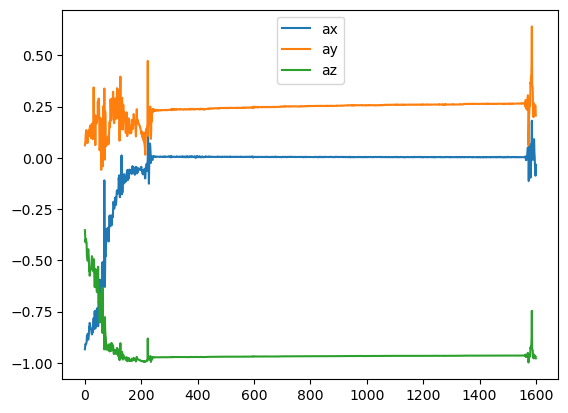

In [14]:
plt.plot(imu.loc[:, "ax"], label="ax")
plt.plot(imu.loc[:, "ay"],label ="ay")
plt.plot(imu.loc[:, "az"], label= "az")
plt.legend()

If we want to handle the gravity we have to substract $\begin{pmatrix}0\\0\\1 \end{pmatrix} $. However, since we are not holding the pen perfectly aligned to one of the axes we will in each step use the rotation matrix to transform the gravity vector which is given in the global frame to the body frame and then substract from the acceleration also measured in the body frame.

In [15]:
def nav_g(R: np.ndarray):
        nav_g = R.T @ [0,0,1]
        return nav_g 
imu[["nav_g_x","nav_g_y","nav_g_z"]] = imu.apply(lambda row: pd.Series(nav_g(row.R_b_g)), axis=1) 

In [16]:
imu[["nav_g_x","nav_g_y","nav_g_z"]].head()

,nav_g_x,nav_g_y,nav_g_z
0,-0.916409,-0.176167,-0.359389
1,-0.913030,-0.181027,-0.365521
2,-0.909929,-0.184972,-0.371233
3,-0.906718,-0.189228,-0.376902
4,-0.903637,-0.192941,-0.382380


In [17]:
imu["fixed_ax"] = imu.apply(lambda row: pd.Series(row.ax - row.nav_g_x), axis=1) 
imu["fixed_ay"] = imu.apply(lambda row: pd.Series(row.ay - row.nav_g_y), axis=1) 
imu["fixed_az"] = imu.apply(lambda row: pd.Series(row.az - row.nav_g_z), axis=1) 

imu[["fixed_ax", "fixed_ay", "fixded_az"]] = normalize(imu[["fixed_ax", "fixed_ay", "fixed_az"]], axis=1, norm='l2')

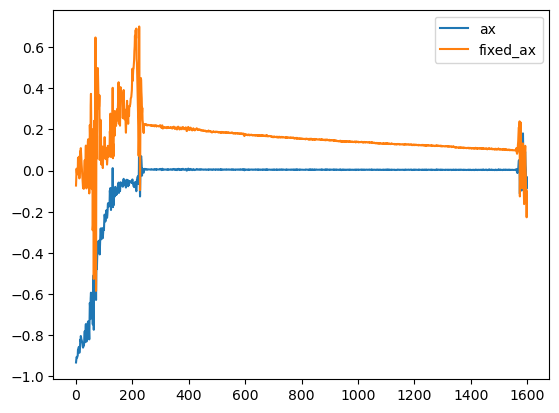

In [18]:
plt.plot(imu.loc[:, "ax"], label="ax")
plt.plot(imu.loc[:, "fixed_ax"],label ="fixed_ax")
plt.legend()

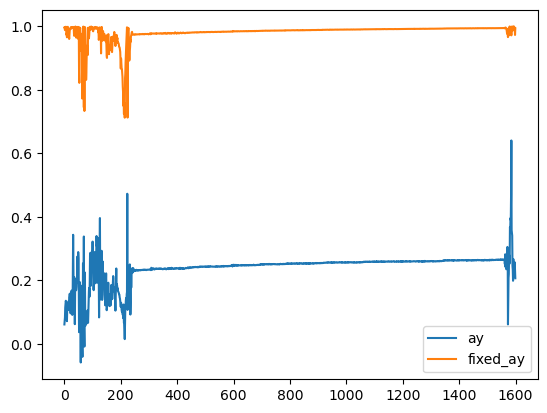

In [19]:
plt.plot(imu.loc[:, "ay"], label="ay")
plt.plot(imu.loc[:, "fixed_ay"],label ="fixed_ay")
plt.legend()

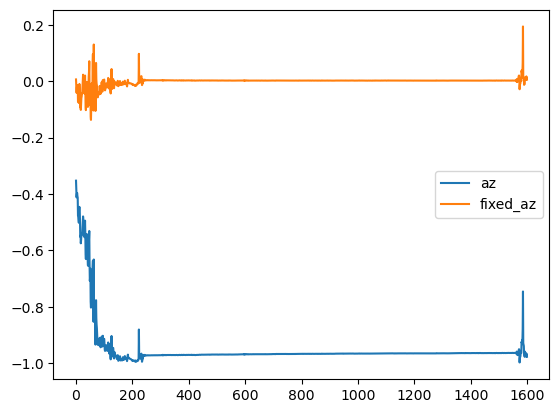

In [20]:
plt.plot(imu.loc[:, "az"], label="az")
plt.plot(imu.loc[:, "fixed_az"],label ="fixed_az")
plt.legend()

In [21]:
def navigation_acc(R: np.ndarray, acc: list):
    nav_acc = R @ acc
    return nav_acc[0], nav_acc[1], nav_acc[2] 
imu[['nav_ax', 'nav_ay', 'nav_az']] = imu.apply(lambda row: pd.Series(navigation_acc(row.R_b_g, [row.ax, row.ay, row.az])), axis=1) 

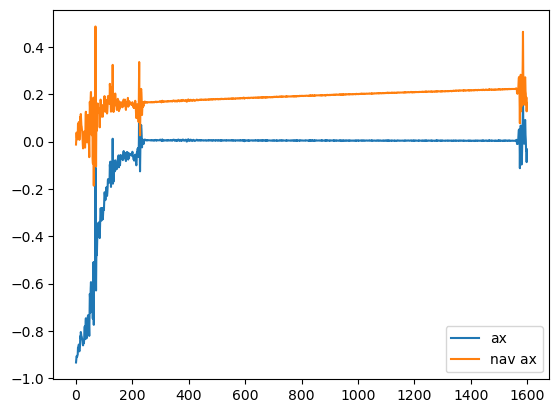

In [22]:
plt.plot(imu.loc[:, "ax"], label="ax")
plt.plot(imu.loc[:, "nav_ax"],label ="nav ax")
plt.legend()

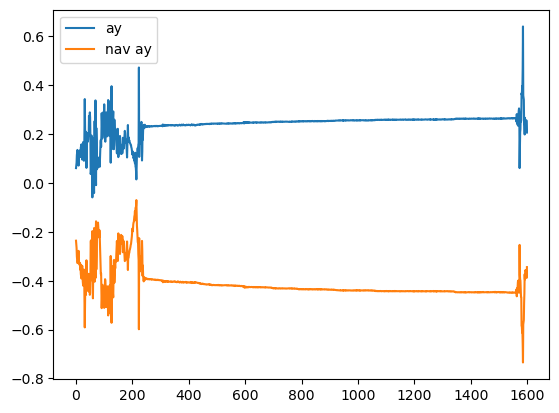

In [23]:
plt.plot(imu.loc[:, "ay"], label="ay")
plt.plot(imu.loc[:, "nav_ay"],label ="nav ay")
plt.legend()

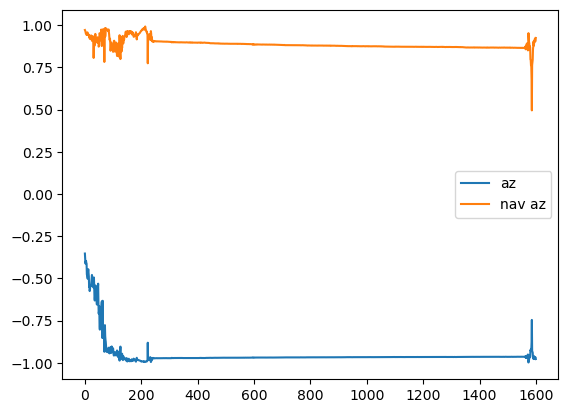

In [24]:
plt.plot(imu.loc[:, "az"], label="az")
plt.plot(imu.loc[:, "nav_az"],label ="nav az")
plt.legend()

### Merged data


In [68]:
PATH_TO_DATA = "./data/"

imu = pd.read_csv(PATH_TO_DATA + "set1_imu.csv", encoding="utf-8")
tab = pd.read_csv(PATH_TO_DATA + "set1_tab.csv", encoding="utf-16")

imu[["ax", "ay", "az"]] = normalize(imu[["ax", "ay", "az"]], axis=1, norm='l2')

In [69]:
def merge_data_based_on_tab(tab, imu, smoothness, step):
        """
        Input: 
            imu: pd.DataFrame with columns [host_timestamp, arduino_timestamp, ax, ay, az, gx, gy, gz, temperature]
            tab: pd.DataFrame with columns [host_timestamp, x, y, z, in_range, touch, pressure, reset]

        Output: 
            pd.DataFrame containing imu and tab data 
        """

        print("merging the data sets...")

        t_left, t_right = tab["host_timestamp"].iloc[[0, -1]]
        i_left, i_right = imu["host_timestamp"].iloc[[0, -1]]
        left = max(t_left, i_left) #later start
        right = min(t_right, i_right) #earlier ending

        # use tab data set as base to merge on
        df = tab[(tab["host_timestamp"] >= left) & (tab["host_timestamp"] <= right)].copy() 

        is_entering_range = df["in_range"].diff() == 1
        is_reset_in_range = (df["in_range"] == 1) & (df["reset"] == 1)
        is_start_of_segment = is_entering_range | is_reset_in_range
        
        # Number segments
        df["segment"] = is_start_of_segment.cumsum()
        
        # Ignore parts that are out-of-range
        df = df[df["in_range"] == 1]

        # collect all segments in this dictonary with key= segment(int), value= dataframe
        dfs = dict()
        segment = 0

        for _, df in df.groupby("segment"):

            data = pd.DataFrame()

            mask = df["touch"] > 0.0
            if not mask.any():
                continue
            start, end = df.index[mask][[0, -1]] # mask hat für die gesamte colum true/false werte und start/end sind erste letzte true werte
            df = df.loc[start:end]

            imu_start = imu.loc[(imu['host_timestamp']-df["host_timestamp"].loc[start]).abs().argsort()[:1]].index[0]
            imu_end = imu.loc[(imu['host_timestamp']-df["host_timestamp"].loc[end]).abs().argsort()[:1]].index[0]

            imu_df = imu.iloc[imu_start:imu_end]

            # Compute distance
            x = df["x"].values
            y = df["y"].values
            dx = np.diff(x, prepend=x[0])
            dy = np.diff(y, prepend=y[0])
            d = np.sqrt(dx ** 2 + dy ** 2)
            t = np.cumsum(d)
            length = t[-1]

            # Fit cubic splines
            mask = d > 1e-5
            if mask.sum() <= 3:
                continue
            tck, _ = scipy.interpolate.splprep([x[mask], y[mask]], u=t[mask], s=smoothness)

            # Sample spline at regular (spatial) interval
            data["t_r"] = np.arange(0, length, step)
            x_r, y_r = scipy.interpolate.splev(data["t_r"], tck, der=0)

            data["x"] = x_r
            data["y"] = y_r

            #interpolate z values
            t_tab = df["host_timestamp"] - np.min(df["host_timestamp"])
            tab_time_span = np.linspace(0, np.max(t_tab), len(data))

            data["z"] = np.interp(tab_time_span, t_tab, df["z"])

            t_imu = imu_df["host_timestamp"] - np.min(imu_df["host_timestamp"])
            imu_time_span = np.linspace(0, np.max(t_imu), len(data))

            # interpolate imu data to the same time span but accoring to the imu time values
            for column in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
                data[column] = np.interp(imu_time_span, t_imu, imu_df[column])

            # Use small dtypes => WHY???
            # x_r = x_r.astype(np.float32)
            # y_r = y_r.astype(np.float32)

            dfs[segment] = data
            segment = segment + 1

        df = pd.concat([df.assign(segment=k) for k,df in dfs.items()])

        return df


In [70]:
data = merge_data_based_on_tab(imu=imu, tab=tab, smoothness=200, step=0.5)

merging the data sets...


In [71]:
data.head()
data = data[data["segment"]==5]

In [72]:
def quaternions(df: pd.DataFrame):
    T = df["t_r"].values
    A = df[["ax", "ay", "az"]].values
    G = df[["gx", "gy", "gz"]].values
    Q = np.zeros((len(T), 4))
    Q[0] = ahrs.common.orientation.acc2q(A[0]) 
    for i in range(1, len(T)):
        madgwick.Dt = (T[i] - T[i - 1]) 
        Q[i] = madgwick.updateIMU(Q[i - 1], G[i], A[i])
    df_q = pd.concat([df.reset_index(drop=True), pd.DataFrame(Q, columns=['q0','q1','q2','q3'])], axis=1)

    return df_q

In [73]:
def integrate_1d(t, dx, x0=0):
    (n,) = dx.shape
    x = np.zeros_like(dx)
    x[0] = x0
    for i in range(1, n):
        dt = (t[i] - t[i - 1]) 
        x[i] = (dx[i - 1] + dx[i]) / 2 * dt + x[i - 1]
        
    return x

def integrate(df):
    T = df["t_r"].values
    vel_x = integrate_1d(T,df['nav_ax'])
    vel_y = integrate_1d(T,df['nav_ay'])
    vel_z = integrate_1d(T,df['nav_az'])

# use starting point tab as intial integration start
    pos_x = integrate_1d(T,vel_x, df.x[0])
    pos_y = integrate_1d(T,vel_y, df.y[0])
    pos_z = integrate_1d(T,vel_z, df.z[0])

    return vel_x, vel_y,vel_z,pos_x,pos_y,pos_z

In [74]:
def add_xy_delta_values(df:pd.DataFrame):
    df['dx'] = df['x'] - df['x'].shift(1)
    df['dy'] = df['y'] - df['y'].shift(1)
    # introduces NaN values in the beginning
    df['dx'] = df['dx'].fillna(0)
    df['dy'] = df['dy'].fillna(0)
    return df


In [75]:
def process_dataframe(df: pd.DataFrame):
    df = quaternions(df)
    print("calculate the rotation matrices...")
    df['r'] = df.apply(lambda row: rotation_matrix([row.q0, row.q1, row.q2, row.q3]), axis=1)
    print("calculate the navigation frame representation...")
    df[['nav_ax', 'nav_ay', 'nav_az']] = df.apply(lambda row: pd.Series(navigation_acc(row.r, [row.ax, row.ay, row.az])), axis=1) 

    print("integrate the acceleration...")
    vel_x, vel_y,vel_z,pos_x, pos_y, pos_z = integrate(df)
    integrated_data = np.stack((vel_x, vel_y, vel_z, pos_x, pos_y, pos_z), axis=1)
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame(integrated_data, columns=['vel_x','vel_y','vel_z', 'pos_x', 'pos_y', 'pos_z'])], axis=1)
    df = add_xy_delta_values(df)
    return df

In [76]:
data = process_dataframe(data)

calculate the rotation matrices...
calculate the navigation frame representation...
integrate the acceleration...


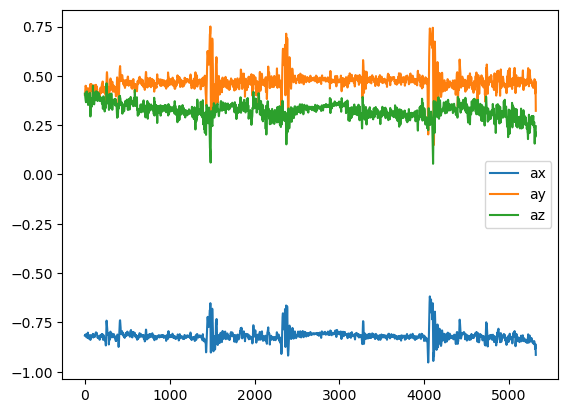

In [77]:
plt.plot(data.ax, label="ax")
plt.plot(data.ay, label="ay")
plt.plot(data.az, label="az")
plt.legend()

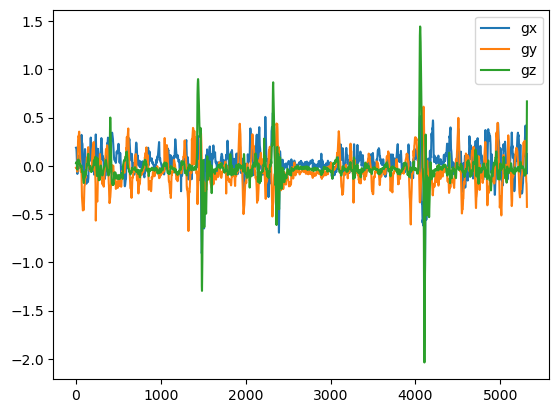

In [78]:
# choose random segment, (5)
plt.plot(data.gx, label="gx")
plt.plot(data.gy, label="gy")
plt.plot(data.gz, label="gz")
plt.legend()

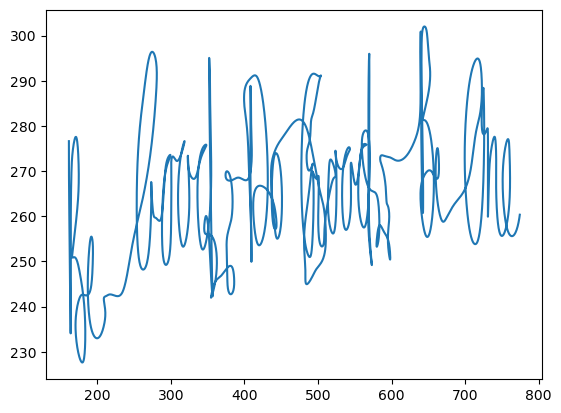

In [79]:
plt.plot(data.x,data.y)

In [80]:
def nav_g(R: np.ndarray):
        nav_g = R.T @ [0,0,1]
        return nav_g 
data[["nav_g_x","nav_g_y","nav_g_z"]] = data.apply(lambda row: pd.Series(nav_g(row.r)), axis=1) 

In [81]:
data["fixed_ax"] = data.apply(lambda row: pd.Series(row.ax - row.nav_g_x), axis=1) 
data["fixed_ay"] = data.apply(lambda row: pd.Series(row.ay - row.nav_g_y), axis=1) 
data["fixed_az"] = data.apply(lambda row: pd.Series(row.az - row.nav_g_z), axis=1) 

#data[["fixed_ax", "fixed_ay", "fixed_az"]] = normalize(data[["fixed_ax", "fixed_ay", "fixed_az"]], axis=1, norm='l2')

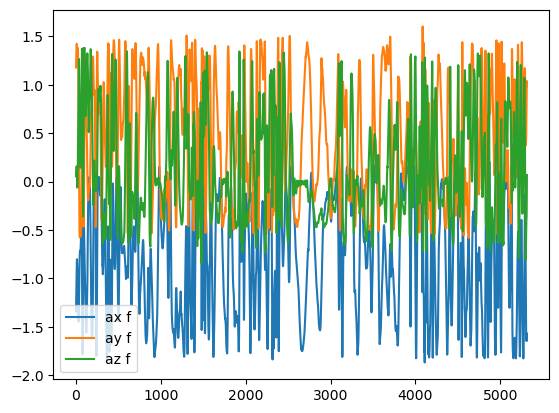

In [82]:
plt.plot(data.fixed_ax, label="ax f")
plt.plot(data.fixed_ay, label="ay f")
plt.plot(data.fixed_az, label="az f")
plt.legend()